# Imports and Variables

In [1]:
import os
import boto3
from botocore.exceptions import ClientError
import logging
import sagemaker
from sagemaker import get_execution_role
from time import gmtime, strftime, sleep
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [2]:
aws_user = os.environ['AWS_USER']
aws_key = os.environ['AWS_KEY']
region_name = 'eu-central-1'

session = boto3.session.Session(
    aws_access_key_id=aws_user,
    aws_secret_access_key=aws_key,
    region_name=region_name)

s3_client = session.client('s3')
s3 = session.resource('s3')

region_name = 'eu-central-1'
bucket_name = 'niy-certification'

role = 'arn:aws:iam::898627427171:role/service-role/AmazonSageMaker-ExecutionRole-20201106T104926'

# Hierarchical Approach

## Dataset

In [3]:
def get_preproccessed_df(s3_link):
    df_raw = pd.read_csv(s3_link, dtype={'DAY_OF_MONTH': str, 'CRS_ARR_TIME': str, 'CRS_DEP_TIME': str, 'WHEELS_OFF': str})
    columns_to_drop = ['YEAR', 'MONTH', 'FL_DATE', 'ORIGIN_STATE_NM', 'DEST_CITY_NAME', 'DEST_STATE_NM', 'DEP_TIME', 
                       'DEP_TIME_BLK', 'ARR_TIME', 'ARR_TIME_BLK', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 
                       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FLIGHTS', 'Unnamed: 54', 
                       'OP_CARRIER_AIRLINE_ID',	'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID',	
                       'ORIGIN_CITY_MARKET_ID',	'ORIGIN_STATE_FIPS', 'DEST_AIRPORT_ID',	'DEST_AIRPORT_SEQ_ID',	
                       'DEST_CITY_MARKET_ID', 'DEST_STATE_FIPS', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 
                       'WHEELS_ON', 'ARR_DELAY', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 
                       'AIR_TIME', 'OP_CARRIER',
                       'TAIL_NUM', # TO CHECK
                       'ORIGIN_CITY_NAME' # TO CHECK
                       ]
    # drop flights which are either canceled or diverted
    # as this is a conceptually different thing than being delayed
    df_raw = df_raw.drop(df_raw.index[(df_raw['CANCELLED'] == 1) | 
                         (df_raw['DIVERTED'] == 1)]).reset_index(drop=True)
    
    # df_raw['DAY_OF_MONTH'] = df_raw['DAY_OF_MONTH'].astype(float)
    
    df_raw = df_raw.drop(columns_to_drop, axis=1)
    df_raw = df_raw.drop(['CANCELLED', 'DIVERTED'], axis=1)
    
    # to get label column up front
    df_raw = df_raw[sorted(df_raw.columns)]
    
    return df_raw

In [4]:
base_path = 'https://niy-certification.s3.eu-central-1.amazonaws.com/usdot/'
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
years = ['_2019', '_2020']

file_uris = {}
for year in years:
    for month in months:
        file_uris[month + year] = base_path + month + year + '_usdot.csv'
        
df = get_preproccessed_df(file_uris['Jan_2019'])

In [6]:
df['ARR_DELAY_BINARY'] = df['ARR_DELAY_NEW'] > 15
df_class = df.drop('ARR_DELAY_NEW', axis=1)

X = df_class.drop('ARR_DELAY_BINARY', axis=1)
y = df_class['ARR_DELAY_BINARY']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42, 
                                                    stratify=y)

In [7]:
X_train = pd.get_dummies(X_train)
# quick implementation, assuming that set of categories is equal in both X_train & X_test
X_test = pd.get_dummies(X_test)

## Classification

In [ ]:
1+2

In [8]:
xgb_class = xgb.XGBClassifier()
xgb_class.fit(X_train, y_train)
y_pred = xgb_class.predict(X_test)
f1_class = f1_score(y_test, y_pred)
print(round(f1_class, 2))

KeyboardInterrupt: 

In [ ]:
plot_confusion_matrix(xgb_class, X_test, y_test);

In [ ]:
# Create new dataframe from X_test

# df_hierarchical, has a true arrival delay label based on the indices from df
# df_hierarchical, has a predicted arrival delay label, which assumes 0 minutes of delay when predicted as punctual and y minutes of delay if predicted as delayed

# use df_hierarchical to train-test split and regress and calcuclate r2-score

In [119]:
df_hierarchical = df.loc[y_test.index].copy()
df_hierarchical = df_hierarchical.drop('ARR_DELAY_BINARY', axis=1)
df_hierarchical['PREDICTED_BINARY'] = y_test

df_hierarchical_regression = df_hierarchical.loc[df_hierarchical['PREDICTED_BINARY'] == True].copy()
df_hierarchical_regression = df_hierarchical_regression.drop('PREDICTED_BINARY', axis=1)

X_hierarchical = df_hierarchical_regression.drop('ARR_DELAY_NEW', axis=1)
y_hierarchical = df_hierarchical_regression['ARR_DELAY_NEW']

X_train_hierarchical, X_test_hierarchical, \
y_train_hierarchical, y_test_hierarchical = train_test_split(X_hierarchical, 
                                                y_hierarchical, 
                                                test_size=0.2,
                                                random_state=42)

In [120]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(X_train_hierarchical.select_dtypes(include='object'))

# enc.transform(test).toarray()

OneHotEncoder(handle_unknown='ignore')

In [121]:
X_train_hierarchical_ohe = pd.DataFrame(data = enc.transform(X_train_hierarchical.select_dtypes(include='object')).toarray(),
             columns = enc.get_feature_names(), index=X_train_hierarchical.index)

In [122]:
X_train_hierarchical = pd.concat([X_train_hierarchical.drop(X_train_hierarchical.select_dtypes(include='object').columns, axis=1),
          X_train_hierarchical_ohe], axis=1)

In [123]:
X_test_hierarchical_ohe = pd.DataFrame(data=enc.transform(X_test_hierarchical.select_dtypes(include='object')).toarray(),
                                       columns = enc.get_feature_names(), index=X_test_hierarchical.index)

In [124]:
X_test_hierarchical = pd.concat([X_test_hierarchical.drop(X_test_hierarchical.select_dtypes(include='object').columns, axis=1),
          X_test_hierarchical_ohe], axis=1)

In [125]:
X_train_hierarchical.shape, X_test_hierarchical.shape

((18101, 826), (4526, 826))

In [128]:
X_train_hierarchical.columns == X_test_hierarchical.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [130]:
xgb_reg = xgb.XGBRegressor()
# Fit the Regressor
xgb_reg.fit(X_train_hierarchical, y_train_hierarchical)
# Predict the response for the test dataset
y_pred_hierarch = xgb_reg.predict(X_test_hierarchical)
# Print r2_score
r2_score = r2_score(y_test_hierarchical, y_pred_hierarch)

In [131]:
r2_score

-0.11914008375879104

<AxesSubplot:ylabel='ARR_DELAY_NEW'>

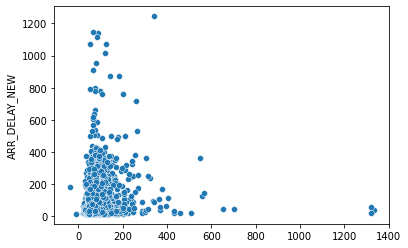

In [134]:
sns.scatterplot(x=y_pred_hierarch, y=y_test_hierarchical);

In [166]:
df_hierarchical_regression.loc[X_train_hierarchical.index, 'ARR_DELAY_NEW'].describe()

count    18101.000000
mean        70.409646
std         96.217837
min         16.000000
25%         24.000000
50%         41.000000
75%         79.000000
max       1556.000000
Name: ARR_DELAY_NEW, dtype: float64

In [165]:
df_hierarchical_regression.loc[X_test_hierarchical.index, 'ARR_DELAY_NEW'].describe()

count    4526.000000
mean       69.050376
std        89.823395
min        16.000000
25%        24.000000
50%        40.000000
75%        77.000000
max      1244.000000
Name: ARR_DELAY_NEW, dtype: float64

In [172]:
pd.Series(y_pred_hierarch).describe()

count    4526.000000
mean       70.709160
std        51.223225
min       -39.189770
25%        50.654150
50%        61.776575
75%        76.751347
max      1333.832031
dtype: float64